In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
%matplotlib inline

import pandas as pd
#import numpy as np
#from matplotlib import pyplot as plt
#import seaborn as sns
#%pylab inline

## Perceptron

In [2]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2, 3)]  # petal length, petal width
y = (iris.target == 0).astype(np.int)

per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys


In [3]:
y_pred

array([1])

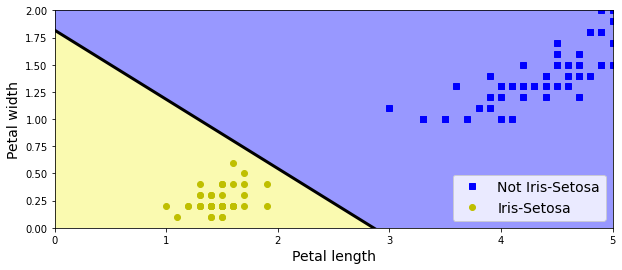

In [4]:
a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]

axes = [0, 5, 0, 2]

x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="Iris-Setosa")

plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)

plt.show()

## Activation Function

In [5]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

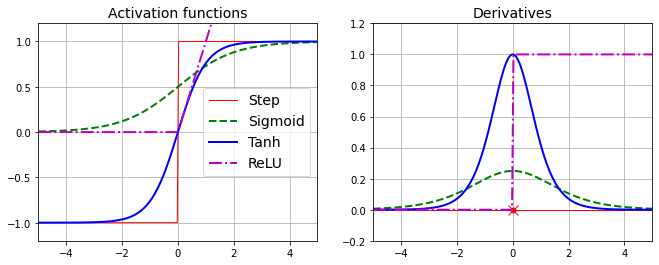

In [6]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
#plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])


plt.show()

In [7]:
def heaviside(z):
    return (z >= 0).astype(z.dtype)

def mlp_xor(x1, x2, activation=heaviside):
    return activation(-activation(x1 + x2 - 1.5) + activation(x1 + x2 - 0.5) - 0.5)

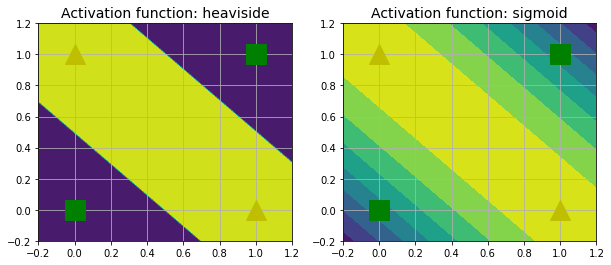

In [8]:
x1s = np.linspace(-0.2, 1.2, 100)
x2s = np.linspace(-0.2, 1.2, 100)
x1, x2 = np.meshgrid(x1s, x2s)

z1 = mlp_xor(x1, x2, activation=heaviside)
z2 = mlp_xor(x1, x2, activation=sigmoid)

plt.figure(figsize=(10,4))

plt.subplot(121)
plt.contourf(x1, x2, z1)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: heaviside", fontsize=14)
plt.grid(True)

plt.subplot(122)
plt.contourf(x1, x2, z2)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: sigmoid", fontsize=14)
plt.grid(True)


## Classification with NN

In [9]:
import tensorflow as tf
from tensorflow import keras

In [10]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [11]:
X_train_full.shape

(60000, 28, 28)

In [12]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

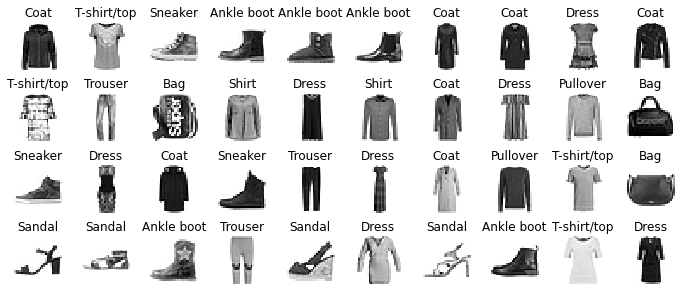

In [14]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

plt.show()

In [15]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


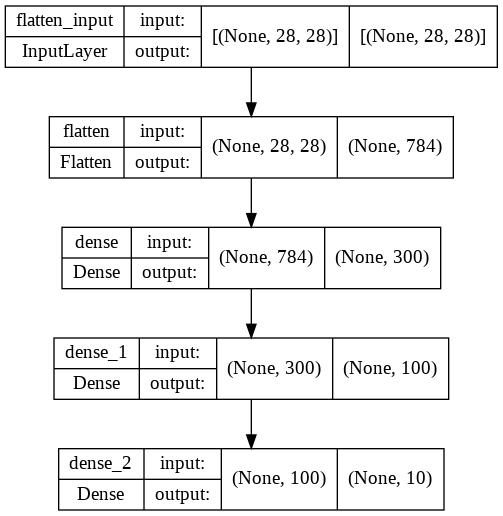

In [17]:
keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

In [18]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])


In [19]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 9s 5ms/step - loss: 0.7237 - accuracy: 0.7643 - val_loss: 0.5213 - val_accuracy: 0.8226
Epoch 2/30
1719/1719 [==============================] - 14s 8ms/step - loss: 0.4842 - accuracy: 0.8318 - val_loss: 0.4353 - val_accuracy: 0.8526
Epoch 3/30
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4391 - accuracy: 0.8457 - val_loss: 0.5333 - val_accuracy: 0.7988
Epoch 4/30
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4123 - accuracy: 0.8564 - val_loss: 0.3916 - val_accuracy: 0.8650
Epoch 5/30
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3939 - accuracy: 0.8616 - val_loss: 0.3741 - val_accuracy: 0.8698
Epoch 6/30
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3751 - accuracy: 0.8678 - val_loss: 0.3706 - val_accuracy: 0.8726
Epoch 7/30
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3630 - accuracy: 0.8715 - val_loss: 0.3621 - val_accuracy

In [22]:
history.params

{'epochs': 30, 'steps': 1719, 'verbose': 1}

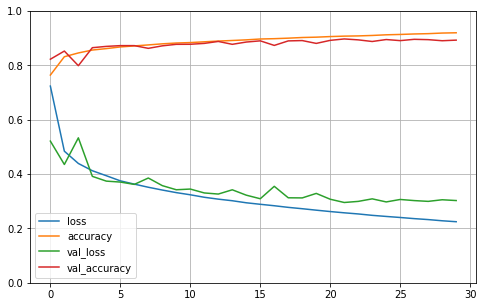

In [23]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)

plt.show()

In [24]:
model.evaluate(X_test, y_test)

162/162 [==============================] - 0s 1ms/step - loss: 3.5110


3.5109670162200928

In [25]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[-0.13],
       [ 0.07],
       [ 1.06]], dtype=float32)

In [26]:
#y_pred = model.predict_classes(X_new) # deprecated
y_pred = np.argmax(model.predict(X_new), axis=-1)
y_pred

array([0, 0, 0])

In [27]:
y_new = y_test[:3]
y_new

array([0.477  , 0.458  , 5.00001])

## Regression MLP


In [29]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [30]:
np.random.seed(42)
tf.random.set_seed(42)
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 1.6419 - val_loss: 0.8560
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.7047 - val_loss: 0.6531
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6345 - val_loss: 0.6099
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5977 - val_loss: 0.5658
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5706 - val_loss: 0.5355
Epoch 6/20
363/363 [==============================] - 1s 4ms/step - loss: 0.5472 - val_loss: 0.5173
Epoch 7/20
363/363 [==============================] - 2s 4ms/step - loss: 0.5288 - val_loss: 0.5081
Epoch 8/20
363/363 [==============================] - 2s 6ms/step - loss: 0.5130 - val_loss: 0.4799
Epoch 9/20
363/363 [==============================] - 2s 5ms/step - loss: 0.4992 - val_loss: 0.4690
Epoch 10/20
363/363 [==============================] - 2s 5ms/step - loss: 0.4875 - val_loss: 0.4656

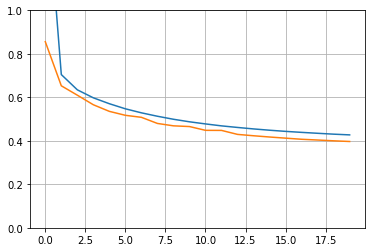

In [31]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

## Hyperparameter Tuning


In [32]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [33]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [34]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """Entry point for launching an IPython kernel.


In [35]:
keras_reg.fit(X_train, y_train, epochs=100,
              validation_data=(X_valid, y_valid),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100
363/363 [==============================] - 1s 3ms/step - loss: 1.0896 - val_loss: 20.7721
Epoch 2/100
363/363 [==============================] - 1s 2ms/step - loss: 0.7606 - val_loss: 5.0266
Epoch 3/100
363/363 [==============================] - 1s 2ms/step - loss: 0.5456 - val_loss: 0.5490
Epoch 4/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4732 - val_loss: 0.4529
Epoch 5/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4503 - val_loss: 0.4188
Epoch 6/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4338 - val_loss: 0.4129
Epoch 7/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4241 - val_loss: 0.4004
Epoch 8/100
363/363 [==============================] - 1s 4ms/step - loss: 0.4168 - val_loss: 0.3944
Epoch 9/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4108 - val_loss: 0.3961
Epoch 10/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4060 - val_l

In [36]:
mse_test = keras_reg.score(X_test, y_test)

162/162 [==============================] - 0s 1ms/step - loss: 0.3346


In [37]:
y_pred = keras_reg.predict(X_new)

In [38]:
np.random.seed(42)
tf.random.set_seed(42)

In [39]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100)               .tolist(),
    "learning_rate": reciprocal(3e-4, 3e-2)      .rvs(1000).tolist(),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)
rnd_search_cv.fit(X_train, y_train, epochs=100,
                  validation_data=(X_valid, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/100
242/242 [==============================] - 1s 3ms/step - loss: 0.8420 - val_loss: 0.4703
Epoch 2/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4815 - val_loss: 0.4247
Epoch 3/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4519 - val_loss: 0.4052
Epoch 4/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4429 - val_loss: 0.3975
Epoch 5/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4368 - val_loss: 0.3991
Epoch 6/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4340 - val_loss: 0.4031
Epoch 7/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4351 - val_loss: 0.4043
Epoch 8/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4267 - val_loss: 0.3929
Epoch 9/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4258 - val_loss: 0.4040
Epoch 10/100
242/242 [========

RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7fc5155c8850>,
                   param_distributions={'learning_rate': [0.001683454924600351,
                                                          0.02390836445593178,
                                                          0.008731907739399206,
                                                          0.004725396149933917,
                                                          0.0006154014789262348,
                                                          0.0006153331256530192,
                                                          0.0003920021771415983,
                                                          0.01619845322936229,
                                                          0.004779156784872302,
                                                          0.007821074275112298,...
                                                          0.00502142573

In [40]:
rnd_search_cv.best_params_

{'learning_rate': 0.005803602934201024, 'n_hidden': 3, 'n_neurons': 74}

In [41]:
rnd_search_cv.best_score_

-0.31959917147954303

In [42]:
rnd_search_cv.best_estimator_